In [3]:
import json
import pickle
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab, validate=True)

## Retrieving articles from Semantic Scholar using API

In [5]:
api_url="https://api.semanticscholar.org/graph/v1/paper/search?query=constructions&fieldsOfStudy=Linguistics&fields=title,abstract&limit=100"

responses=[]
for offset in range(0,9900,100): #can only retrieve 100 articles at a time

  url = api_url + '&offset=' + str(offset)
  r = requests.get(url)
  data=r.json()['data']
  responses.append(data)

In [ ]:
df=pd.DataFrame([r for d in responses for r in d])
df.head() # df has three columns: paperId, title, abstract

## Regex only approach: not better than Spacy+Regex (see below)

In [ ]:
df['potential_constructions_title'] = df['title'].str.extract('(\w+\W+){1,4}construction|Construction|constructions|Constructions')
df['potential_constructions_abstract'] = df['abstract'].str.extract('(\w+\W+){1,4}construction|Construction|constructions|Constructions')
df.head()

## Spacy dependency parser + Regex

In [10]:
pattern1 = [{'DEP':'amod'},{'TEXT':'-', 'OP':"?"},{'DEP':'amod', 'OP':"?"}, {'DEP':'compound'},{'TEXT':'-', 'OP':"?"}, {'DEP':'compound', 'OP':"*"},
           {'LOWER': 'constructions'}]
pattern2=[{'DEP':'det'}, {"IS_PUNCT": False, "OP": "{1,6}"}, {'LOWER': 'construction'}]
pattern3=[{'DEP':'compound'}, {'DEP':'compound', 'OP':"?"},{'LOWER': 'constructions'}]
pattern4=[{'POS':'PROPN', 'OP':"*"}, {'TEXT':'-'}, {'POS':'PROPN', 'OP':"*"},{'LOWER': 'constructions','OP':"?"},{'LOWER': 'construction'}]
pattern5=[{'DEP':'compound'},{'TEXT':'-', 'OP':"?"}, {'DEP':'compound', 'OP':"*"},{'LOWER': 'constructions'}]
pattern6=[{'DEP':'amod'}, {'LOWER': 'constructions'}]
pattern7=[{'DEP':'amod'},{'TEXT':'-'},{'DEP':'compound'},{'TEXT':'-'}, {'LOWER': 'construction'}]
pattern8=[{'DEP':'amod'}, {'TEXT':'-'}, {'LOWER': 'construction'}]
pattern9=[{'DEP':'amod','OP':"?"},{'DEP':'compound','OP':"?"},{'DEP':'dobj', 'OP':"?"}, {'DEP':'nsubj', 'OP':"?"},{'DEP':'expl', 'OP':"?"},{'DEP':'pobj', 'OP':"?"},{'TEXT':'-'}, {'LOWER': 'construction'}]
pattern10=[{'DEP':'ROOT'},{'DEP':'cc', 'OP':"*"}, {'DEP':'conj', 'OP':"*"}, {'TEXT':'-', 'OP':"*"}, {'LOWER': 'construction'}] #pattern for "The left-subordinating and-construction"
pattern11=[{'LOWER': 'Fluid', 'LOWER': 'Construction', 'LOWER': 'Grammar'}]
pattern12=[{'LOWER': 'Sign-based', 'LOWER': 'Construction', 'LOWER': 'Grammar'}]


matcher.add("matching_1", [pattern1],greedy="LONGEST", on_match=None)
matcher.add("matching_2", [pattern2],greedy="LONGEST", on_match=None)
matcher.add("matching_3", [pattern3],greedy="LONGEST", on_match=None)
matcher.add("matching_4", [pattern4],greedy="LONGEST", on_match=None)
matcher.add("matching_5", [pattern5],greedy="LONGEST", on_match=None)
matcher.add("matching_6", [pattern6],greedy="LONGEST", on_match=None)
matcher.add("matching_7", [pattern7],greedy="LONGEST", on_match=None)
matcher.add("matching_8", [pattern8],greedy="LONGEST", on_match=None)
matcher.add("matching_9", [pattern9],greedy="LONGEST", on_match=None)
matcher.add("matching_10", [pattern10],greedy="LONGEST", on_match=None)
matcher.add("matching_11", [pattern11],greedy="LONGEST", on_match=None)
matcher.add("matching_12", [pattern12],greedy="LONGEST", on_match=None)

In [13]:
# Test the Matcher on an example (used to add/remove patterns)
doc = nlp(u"Relative clause constructions in children with specific language impairment") 
for tok in doc:
    print(tok.i, tok, "[", tok.dep_, "]")  
matches = matcher(doc)
print(doc[matches[0][1]:matches[0][2]]) 

0 Relative [ amod ]
1 clause [ compound ]
2 constructions [ ROOT ]
3 in [ prep ]
4 children [ pobj ]
5 with [ prep ]
6 specific [ amod ]
7 language [ compound ]
8 impairment [ pobj ]
Relative clause constructions


## Retrieving potential construction names 

In [ ]:
df['abstract']= df['abstract'].astype(str)
title=df['title'].tolist()
abstract=df['abstract'].tolist()
title=[i for i in title if str(i) != 'NA']
abstract=[i for i in abstract if str(i) != 'NA']
# Use the Matcher to retrieve all potential constructions in the titles
t=[]
for i in title:
    s=nlp(i)
    matches = matcher(s)
    #print(matches)
    if not matches:
      t.append('NA')
    else:
      c=s[matches[0][1]:matches[0][2]]
      t.append(str(c))
print(t[0:10])



In [ ]:
# Use the Matcher to retrieve all potential constructions in the abstracts
a=[]
for i in abstract:
    s=nlp(i)
    matches = matcher(s)
    #print(matches)
    if not matches:
      a.append('NA')
    else:
      c=s[matches[0][1]:matches[0][2]]
      a.append(str(c))
print(a[0:10])

In [ ]:
# Filtering the results: removing all 'grammatical' constructions
l1=""
t2=[]
remove = ['grammatical', 'Grammatical', 'GRAMMATICAL']
for i in t:
    l1=""
    for j in i.split():
        if j not in remove:
            l1=l1+" " +j
    t2+=[l1]        
        
print(t2[0:10])

l2=""
a2=[]
remove = ['grammatical', 'Grammatical', 'GRAMMATICAL']
for i in a:
    l2=""
    for j in i.split():
        if j not in remove:
            l2=l2+" " +j
    a2+=[l2]        
        
print(a2[0:10])

In [ ]:
# Add new columns
df['spacy_constructions_title'] = t2
df['spacy_constructions_abstract']=a2

## Add the Language column

In [ ]:
with open('language_list.txt') as f: # A list of 85 language names
    lang = [line.rstrip('\n') for line in f]

In [ ]:
# Extract langauge names in titles using language list and make a new column 'language', otherwise fill it with NA 
df['language'] = df.title.str.extract('({})'.format('|'.join(lang)), 
                        flags=re.IGNORECASE, expand=False).str.lower().fillna('NA')

df.head()

## Frequency plot

In [ ]:
# Extra stopwords
N = [ 'NA', 'NaN', 'the', 'The', 'to', 'such', 'and', 'a', 'in', 'it', 'is', 'I', 'that', 'on', 'for', 'of', 'constructions', 'construction', 'Constructions', 'Construction', 'A','THE', 'CONSTRUCTIONS','CONSTRUCTION', '-construction','-Construction']

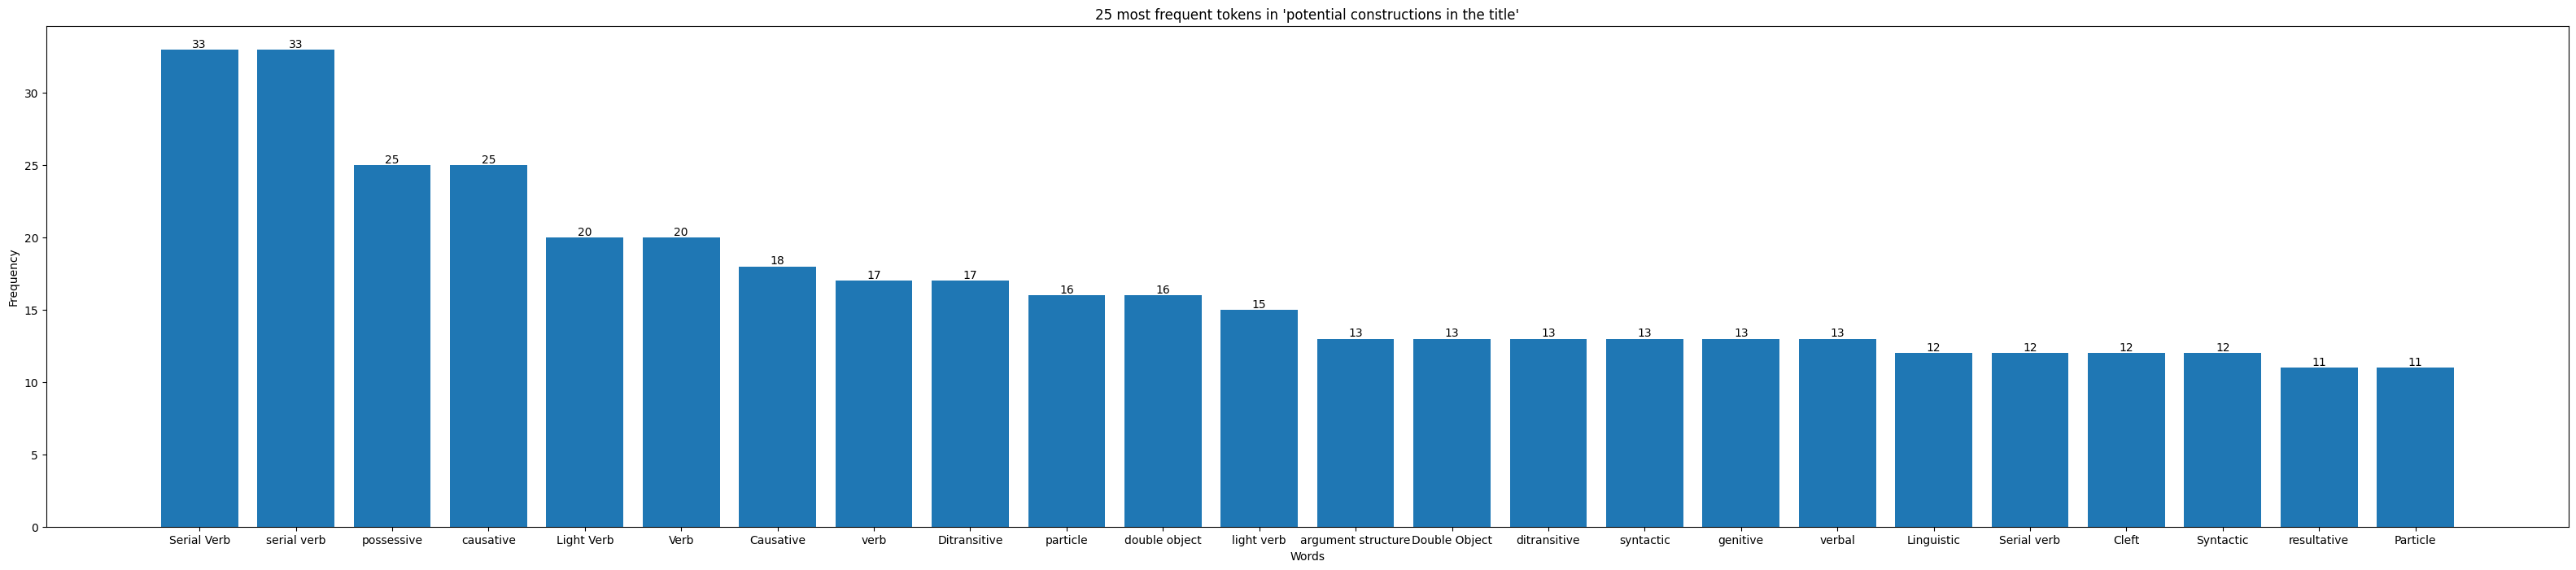

In [ ]:

df['construction_title_without_stopwords'] = df['spacy_constructions_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (N)]))
spacy_title_list = df['construction_title_without_stopwords'].values.tolist()
# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(spacy_title_list).most_common(25) #" ".join(spacy_title_list).split()

# # `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
words.pop(0) #to remove 'space'
counts = [counts for _, counts in word_frequency]
counts.pop(0) #to remove 'space' freq

fig, ax = plt.subplots(figsize=(40, 8))
g=plt.bar(words, counts)

plt.title("25 most frequent tokens in 'potential constructions in the title'")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.bar_label(g, label_type='edge')
plt.show()

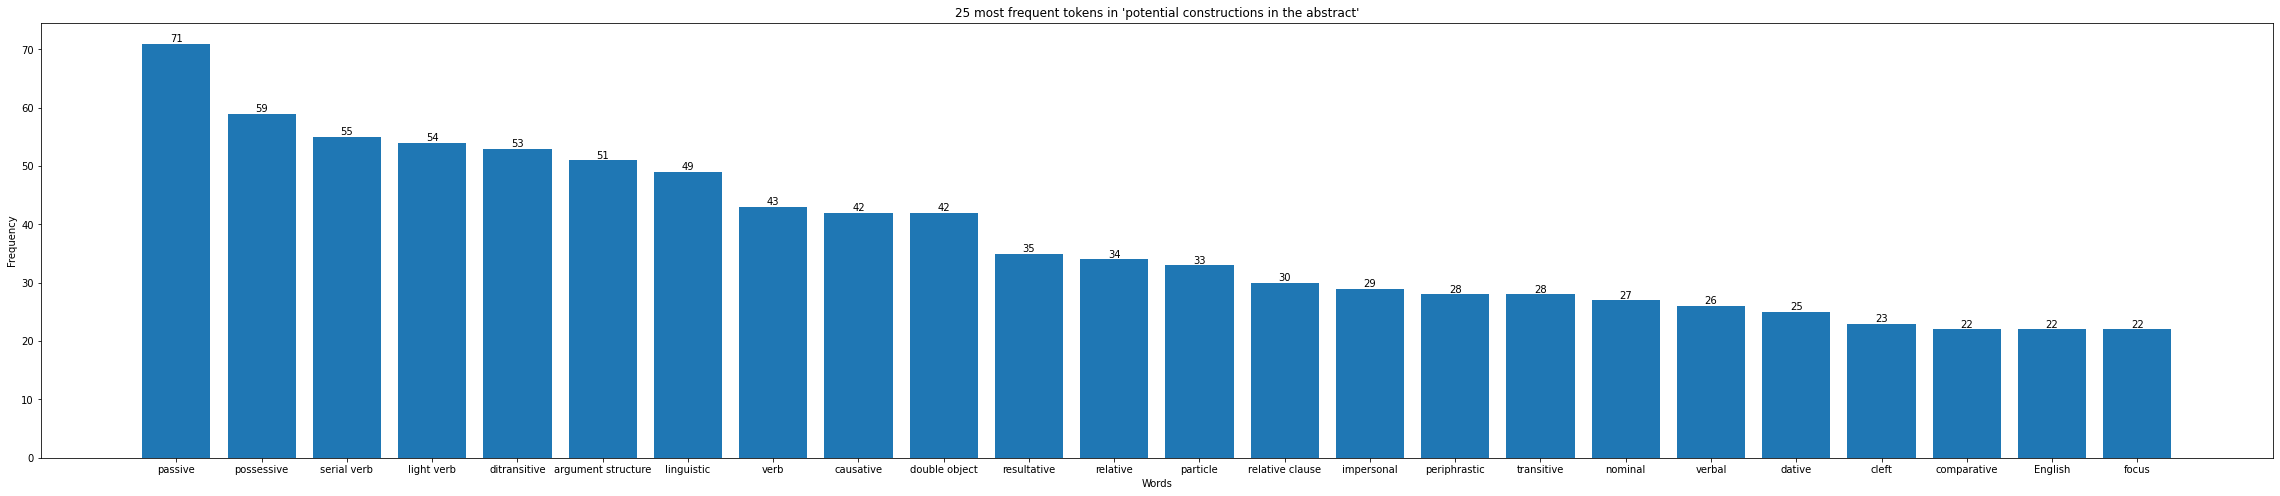

In [ ]:
N2=N+['different','such', 'syntactic']
df['construction_abstract_without_stopwords'] = df['spacy_constructions_abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (N2)]))
spacy_abstract_list = df['construction_abstract_without_stopwords'].values.tolist()
# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(spacy_abstract_list).most_common(25) 

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
words.pop(0) #to remove 'space'
counts = [counts for _, counts in word_frequency]
counts.pop(0) #to remove 'space' freq

fig, ax = plt.subplots(figsize=(40, 8))
g=plt.bar(words, counts)
plt.title("25 most frequent tokens in 'potential constructions in the abstract'")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.bar_label(g, label_type='edge')
plt.show()

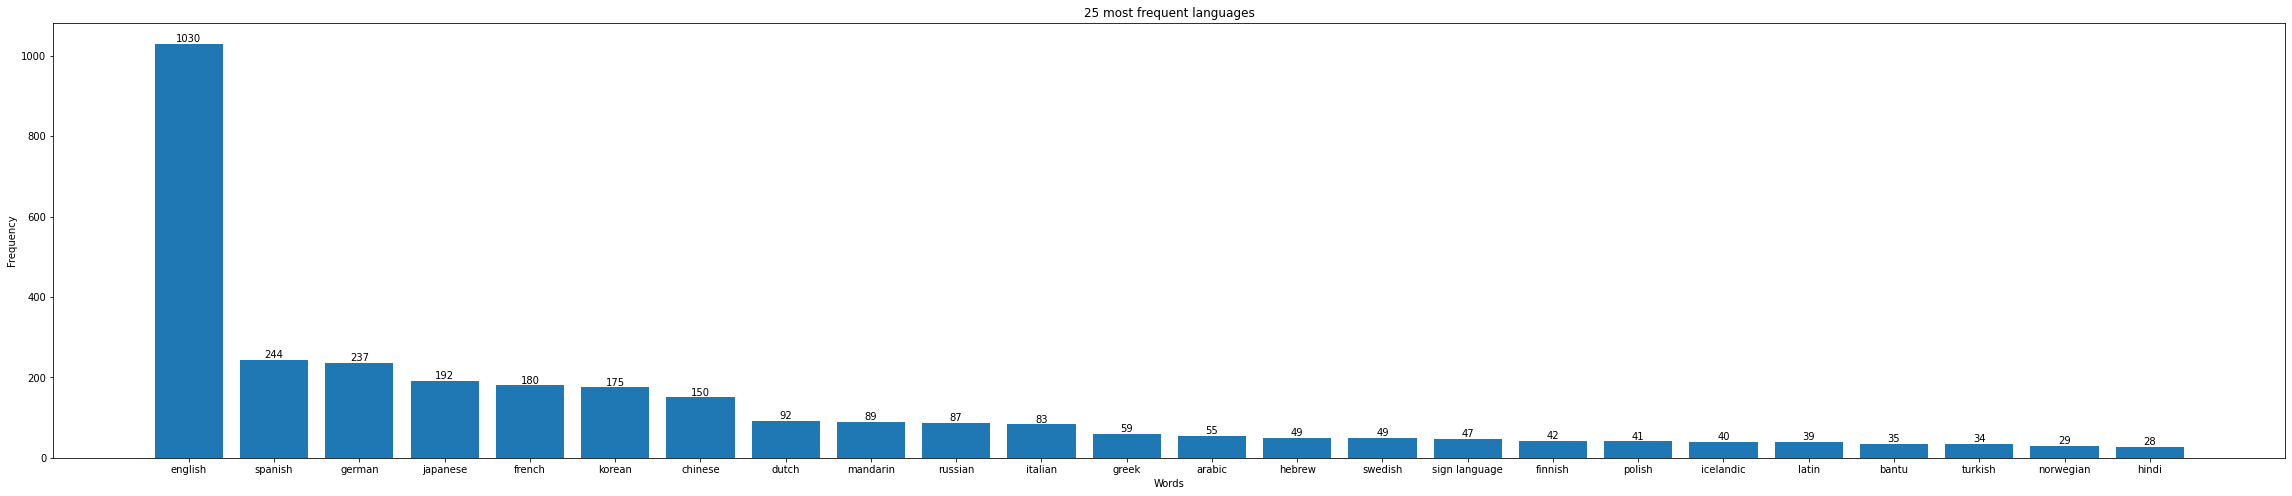

In [ ]:

language_list = df['language'].values.tolist()
# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(language_list).most_common(25) #" ".join(spacy_title_list).split()

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
words.pop(0) #to remove 'nan'
counts = [counts for _, counts in word_frequency]
counts.pop(0) #to remove 'nan' freq

fig, ax = plt.subplots(figsize=(40, 8))
g=plt.bar(words, counts)
plt.title("25 most frequent languages")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.bar_label(g, label_type='edge')
plt.show()

## EDA

In [ ]:
# Top4 frequent languages
eng_df=df.loc[df['language'] == "english"]
span_df=df.loc[df['language'] == "spanish"]
deu_df=df.loc[df['language'] == "german"]
jpn_df=df.loc[df['language'] == "japanese"]

In [ ]:
# Top 30 frequent constructions in each language
eng_df['construction_title_without_stopwords'] = eng_df['spacy_constructions_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (N)]))
eng_spacy_title_list = eng_df['construction_title_without_stopwords'].values.tolist()
# Assign the Counter instance `most_common` call to a variable:
eng_word_frequency = Counter(eng_spacy_title_list).most_common(30) 

# # `most_common` returns a list of (word, count) tuples
eng_words = [word for word, _ in eng_word_frequency]
eng_words.pop(0) #to remove 'space'
eng_counts = [counts for _, counts in eng_word_frequency]
eng_counts.pop(0) #to remove 'space' freq

eng_data_tuples = list(zip(eng_words,eng_counts))
eng_freq=pd.DataFrame(eng_data_tuples, columns=['Words(Eng)','Counts'])
eng_freq

## Clean up the 'potential_constructions_title' column

In [ ]:
pc=df.potential_constructions.tolist()

In [ ]:
# Romove trailing space in string
pc=[s.lstrip() for s in pc]

# Remove all construction names with only "construction" in the list
pc=['na' if s.startswith('construction') or s.startswith('constructions') else s for s in pc]

## TO DO!!!

In [ ]:
# Fix encoding issues like 'forç\x9e½'
from unidecode import unidecode
unidecode("forç\x9e½")

In [ ]:
# Merge constructions like 'verb construction' and 'verb constructions'